In [875]:
import numpy as np
import skimage as sk
import skimage.io as skio
from skimage import io, img_as_ubyte
from skimage.transform import rescale
import time

In [934]:
# name of the input file
imname = 'data/emir.tif'


# read in the image
im = skio.imread(imname)

# convert to double (might want to do this later on to save memory)    
im = sk.img_as_float(im)
    
# compute the height of each part (just 1/3 of total)
height = np.floor(im.shape[0] / 3.0).astype(int)

# separate color channels
b = im[:height]
g = im[height: 2*height]
r = im[2*height: 3*height]

#skio.imshow(np.roll(b, 20, axis = 1))
#print(g.shape)

Heres a crop function that takes in an image, and the percentage of the image you want left (ie use 95 if you want 95% of your image).

In [935]:
def crop(img, percentage):
    height_of_img, width_of_img = img.shape
    new_height = int(height_of_img * percentage/100)
    new_width = int(width_of_img * percentage/100)
    height_crop = ((height_of_img - new_height)//2)
    width_crop = ((width_of_img - new_width)//2)
    return img[height_crop:(new_height - height_crop), width_crop:(new_width - width_crop)]

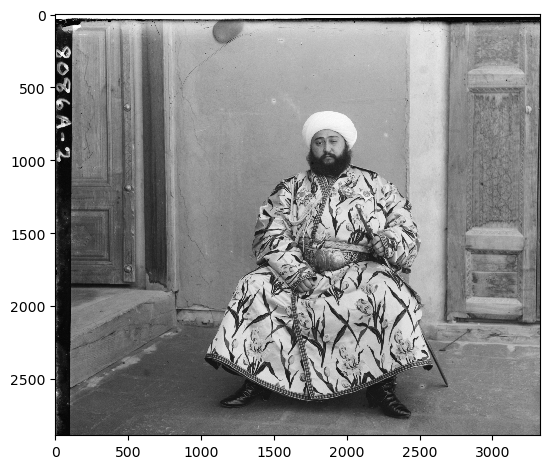

In [936]:
new_b = crop(b, 95)


new_g = crop(g, 95)

new_r = crop(r, 95)

skio.imshow(new_b)

#fname = './aligned_photos/cathedral_after_crop.jpg'
#skio.imsave(fname, img_as_ubyte(new_b))

Here's the Naive implementation of the align function. This takes in two images, and uses simple for loops to look at a window. If you want to change the metric, you have to actually modify the function... no hyperparameters in this naive implementation

In [937]:
# align the images
# functions that might be useful for aligning the images include:
# np.roll, np.sum, sk.transform.rescale (for multiscale)

#align currently used L2, but you can change the inside
def align(im1, im2):
    #lets start simple and simply calculate the eculidean distances between images
    displacement_array = []

    #lets crop im1 and im2
    cropped_im1 = crop(im1, 95) #crop function
    cropped_im2 = crop(im2, 95)

    for i in range(-15, 16):
        for j in range(-15, 16):
            new_im1 = np.roll(cropped_im1, (i,j), axis = (1,0))
            l2_distance = np.linalg.norm(new_im1-cropped_im2)
            normalized_im1 = new_im1.ravel() - np.mean(new_im1)
            normalized_im2 = cropped_im2.ravel() - np.mean(cropped_im2)
            NCC_distance = np.dot(normalized_im1, normalized_im2) / (np.linalg.norm(normalized_im1) * np.linalg.norm(normalized_im2))
            displacement_array.append(l2_distance) #change to NCC_distance
    min_index = np.argmin(displacement_array)
    max_index = np.argmax(displacement_array)
    i,j = np.unravel_index(min_index, (31,31)) #use max if using NCC
    print(i-15,j-15)
    return np.roll(im1, (i-15, j-15), axis = (1,0))

        



Here is my implementation of the image_pyramid. Takes in an image, scae, and iterations. The number of iterations is actually how many times it gets shrunken down. So the total size of the list outputted is iters + 1. 

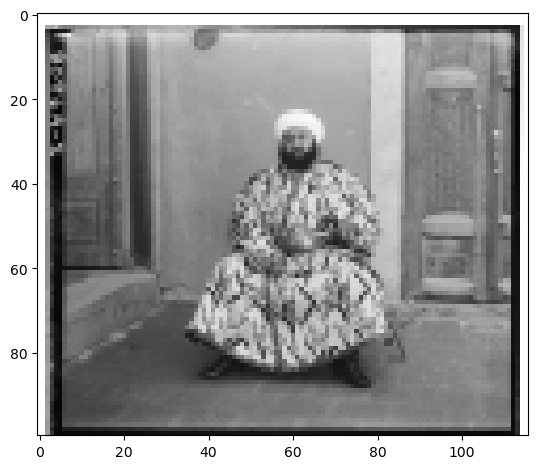

In [ ]:

def image_pyramid(img, scale, iters):
    pyramid = [img]
    if iters == 0:
        return pyramid
    else:
        rescaled_img = rescale(img, scale, anti_aliasing=False)
        new_img = image_pyramid(rescaled_img, scale, iters -1)
        pyramid.extend(new_img)
        return pyramid
    
emir_pyramid = image_pyramid(b, 1/2, 5)

skio.imshow(emir_pyramid[5])

#fname = './aligned_photos/emir_5.jpg'
#skio.imsave(fname, img_as_ubyte(emir_pyramid[5]))


Here's the implementation of my triangle speedup --> align_large. Find roll searches around a known coordinate, with a window size of perturbation. Align_large actually aligns them. 

In [939]:
#this searches around a chosen location, looking at a window with perturbation. Type means what metric we're using to optimize
def find_roll(im1, im2, init_x, init_y, perturbation, type = 0):
    displacement_array = np.zeros((2*perturbation + 1, 2*perturbation + 1))
    for x in range(-perturbation, perturbation + 1):
        for y in range(- perturbation, perturbation + 1):
            new_im1 = np.roll(im1, (x+init_x,y+init_y), axis = (1,0))
            if type == 0: #l1 distance
                distance = np.sum(np.abs(new_im1.ravel()-im2.ravel()))
            elif type == 1: #l2 distance
                distance = np.linalg.norm(new_im1-im2)
            else: #NCC distance
                eps = 1e-10
                normalized_im1 = new_im1.ravel() - np.mean(new_im1)
                normalized_im2 = im2.ravel() - np.mean(im2)
                distance = np.dot(normalized_im1, normalized_im2) / (np.linalg.norm(normalized_im1) * np.linalg.norm(normalized_im2) + eps)
            displacement_array[x+perturbation, y+perturbation] = distance # is this right?
    if type == 0 or type == 1:
        best_index = np.argmin(displacement_array)
    else:
        best_index = np.argmax(displacement_array)
    dx, dy = np.unravel_index(best_index,displacement_array.shape)
    #print(dx-perturbation,dy-perturbation)
    return dx-perturbation, dy - perturbation

#this is the image pyramid speedup!
def align_large(im1, im2, scale, pyramid_size, perturbation, crop_percentage, type=0):
    #lets go do this 3 times. And make small perturbations near the best value
    im1_pyramid = image_pyramid(crop(im1,crop_percentage), scale, pyramid_size)
    im2_pyramid = image_pyramid(crop(im2,crop_percentage), scale, pyramid_size)
    init_x, init_y = 0,0
    if pyramid_size == 0: 
        return align(im1, im2)
    for i in range(pyramid_size, -1, -1):
        new_im1 = im1_pyramid[i]
        new_im2 = im2_pyramid[i]
        #new_x, new_y = search_around(new_im1, new_im2, roll_x, roll_y, perturbation)
        dx, dy = find_roll(new_im1, new_im2, init_x, init_y, perturbation, type)
        init_x += dx
        init_y += dy
        if i > 0:
            init_x = int(init_x/scale)
            init_y = int(init_y/scale)
        perturbation = int(perturbation*scale)  
    print(init_x, init_y)
    return np.roll(im1, (init_x, init_y), axis = (1,0))


Here we fully align the photos. I use align_large for the pyramid speedup. If you uncomment the usual align, you should be able to run the naive implementation

24 50
41 104
9.535163164138794


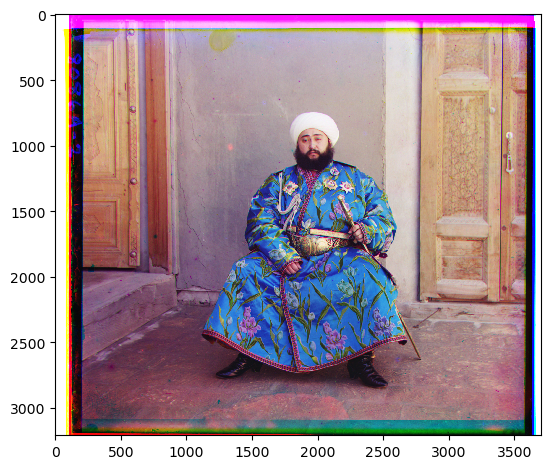

In [940]:
start_time = time.time()
ag = align_large(g, b, 1/2, 3, 30, 95, 0) #Hyperparameters
ar = align_large(r, b, 1/2, 3, 30, 95, 0) #scale, height of pyramid, size to search (which is scaled down by scale), crop_percentage, metric (0 = L1, 1 = L2, 2 = NCC)
#ag = align(g, b) #uncomment these if you want to use the basic alignment
#ar = align(r, b)
end_time = time.time()
print(end_time - start_time)
# create a color image
im_out = np.dstack([ar, ag, b])

# save the image
#fname = './aligned_photos/rainbow.jpg'
#skio.imsave(fname, img_as_ubyte(im_out))

# display the image
skio.imshow(im_out)
skio.show()